<a href="https://colab.research.google.com/github/mneochengrustno/Works/blob/main/Graphs_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

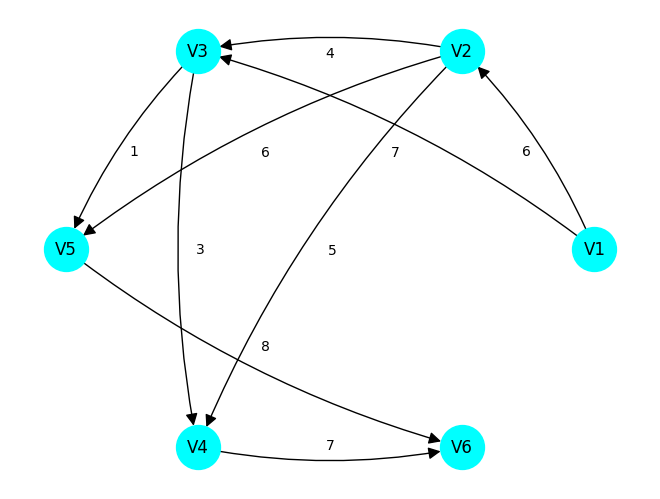

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from collections import deque

G = nx.DiGraph()

edges = [
    ("V1","V2",6),
    ("V1","V3",7),
    ("V2","V3",4),
    ("V2","V5",6),
    ("V2","V4",5),
    ("V3","V4",3),
    ("V3","V5",1),
    ("V4","V6",7),
    ("V5","V6",8),
]

for u, v, w in edges:
    G.add_edge(u, v, weight=w)

pos = nx.circular_layout(G)

options = {
    'node_color': 'cyan',
    'node_size': 1000,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 18,
    'edge_color':'black',
}

nx.draw(G, pos, with_labels=True, arrows=True, connectionstyle="arc3,rad=0.1", **options)

edge_labels = nx.get_edge_attributes(G, "weight")
for (u, v), label in edge_labels.items():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    dx, dy = x2 - x1, y2 - y1
    offset = 0.01
    norm = np.sqrt(dx**2 + dy**2)
    if norm != 0:
        nxm, nym = -dy / norm, dx / norm
    else:
        nxm, nym = 0, 0
    xm_off, ym_off = xm + offset * nxm, ym + offset * nym
    plt.text(xm_off, ym_off, str(label), color="black",
             fontsize=10, ha="center", va="center",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

plt.show()

In [ ]:
def ford_fulkerson_draw(G, s, t, pos, figsize=(8,5)):
    R = {}
    original_capacity = {}
    for u, v, data in G.edges(data=True):
        cap = float(data.get('weight', 0))
        original_capacity[(u, v)] = cap
        R[(u, v)] = cap
        if (v, u) not in R:
            R[(v, u)] = 0.0

    removed_edges = set()
    augmenting_info = []
    def bfs():
        parent = {}
        q = deque([s])
        visited = {s}
        while q:
            u = q.popleft()
            for (a, b), cap in R.items():
                if a == u and cap > 1e-12 and b not in visited:
                    parent[b] = a
                    if b == t:
                        path = []
                        cur = t
                        while True:
                            path.append(cur)
                            if cur == s:
                                break
                            cur = parent[cur]
                        path.reverse()
                        return path
                    visited.add(b)
                    q.append(b)
        return None
    while True:
        path = bfs()
        if path is None:
            break
        bottleneck = min(R[(path[i], path[i+1])] for i in range(len(path)-1))
        augmenting_info.append((path, bottleneck))
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            R[(u, v)] -= bottleneck
            R[(v, u)] += bottleneck
            if (u, v) in original_capacity and R[(u, v)] <= 1e-12:
                removed_edges.add((u, v))

    max_flow = sum(b for _, b in augmenting_info)
    reachable = set()
    stack = [s]
    while stack:
        node = stack.pop()
        if node in reachable:
            continue
        reachable.add(node)
        for (a, b), cap in R.items():
            if a == node and cap > 1e-12 and b not in reachable:
                stack.append(b)

    min_cut_edges = [(u, v) for (u, v) in original_capacity.keys() if u in reachable and v not in reachable]
    for path_nodes, b in augmenting_info:
        print("  Путь:", "->".join(path_nodes), "phi_min =", b)
    print(f"\nМаксимальный поток = {max_flow}")
    print("Ребра минимального разреза:", min_cut_edges)
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color='cyan', node_size=1000)
    nx.draw_networkx_labels(G, pos, font_size=12)

    orig_edges = list(original_capacity.keys())
    red_edges = list(removed_edges)
    green_edges = list(min_cut_edges)
    normal_edges = [e for e in orig_edges if e not in red_edges and e not in green_edges]

    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='black',
                           arrowstyle='-|>', arrowsize=18, connectionstyle="arc3,rad=0.1", width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='red',
                           arrowstyle='-|>', arrowsize=18, connectionstyle="arc3,rad=0.1", width=3.0)
    for (u, v) in orig_edges:
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        xm, ym = (x1 + x2) / 2.0, (y1 + y2) / 2.0
        dx, dy = x2 - x1, y2 - y1
        norm = math.hypot(dx, dy)

        if norm != 0:
            perp_x, perp_y = -dy / norm, dx / norm
        else:
            perp_x, perp_y = 0.0, 0.0

        label_offset = 0.03
        xm_off, ym_off = xm + label_offset * perp_x, ym + label_offset * perp_y

        residual_value = R.get((u, v), 0)
        lbl = int(residual_value) if abs(residual_value - round(residual_value)) < 1e-9 else residual_value
        plt.text(xm_off, ym_off, str(lbl),
                 color="black", fontsize=10, ha="center", va="center",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

        if (u, v) in green_edges:
            # длина штриха = 20% длины ребра
            stroke_len = 0.25
            half = stroke_len / 2
            # смещаем штрих перпендикулярно ребру
            x_start, y_start = xm - perp_x * half, ym - perp_y * half
            x_end,   y_end   = xm + perp_x * half, ym + perp_y * half
            plt.plot([x_start, x_end], [y_start, y_end], color='limegreen', linewidth=3, solid_capstyle='butt')

        residual_value = R.get((u, v), 0)
        plt.text(xm_off, ym_off, str(int(residual_value)),
                 color="black", fontsize=10, ha="center", va="center",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

    plt.title(f"Максимальный поток = {int(max_flow)}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return max_flow, min_cut_edges, removed_edges

  Путь: V1->V2->V5->V6 phi_min = 6.0
  Путь: V1->V3->V4->V6 phi_min = 3.0
  Путь: V1->V3->V5->V6 phi_min = 1.0

Максимальный поток = 10.0
Ребра минимального разреза: [('V1', 'V2'), ('V3', 'V4'), ('V3', 'V5')]


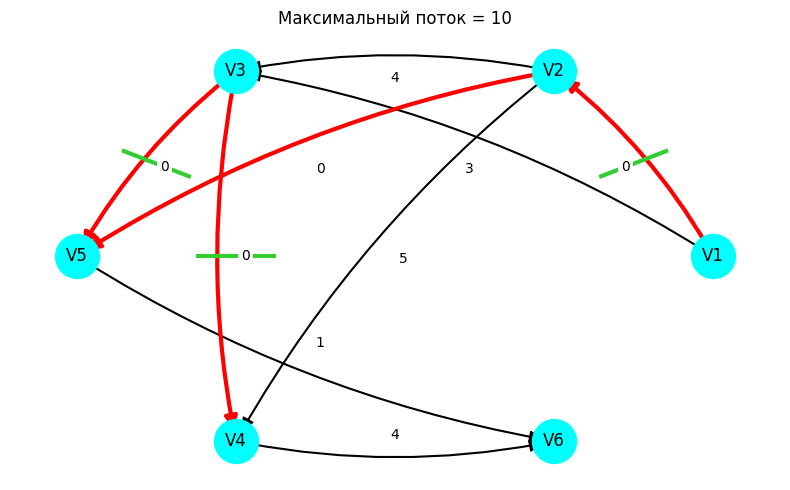

In [ ]:
max_flow, min_cut, removed = ford_fulkerson_draw(G, "V1", "V6", pos)

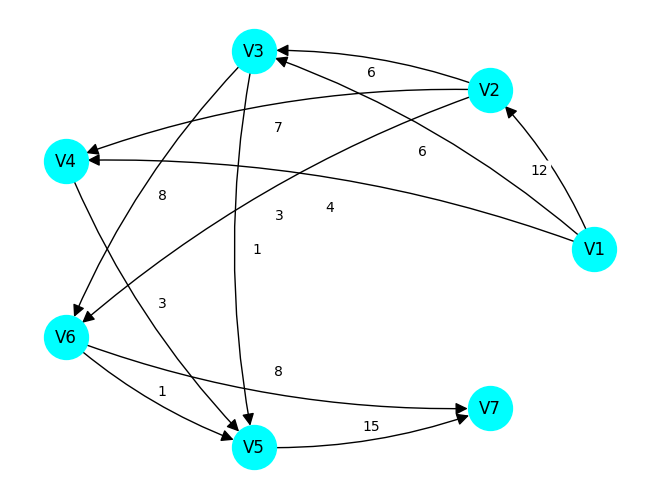

In [ ]:
H = nx.DiGraph()

edges = [
    ("V1","V2",12),
    ("V1","V3",6),
    ("V1","V4",4),
    ("V2","V3",6),
    ("V2","V4",7),
    ("V2","V6",3),
    ("V3","V5",1),
    ("V3","V6",8),
    ("V4","V5",3),
    ("V5","V7",15),
    ("V6","V5",1),
    ("V6","V7",8),
]

for u, v, w in edges:
    H.add_edge(u, v, weight=w)

pos = nx.circular_layout(H)

options = {
    'node_color': 'cyan',
    'node_size': 1000,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 18,
    'edge_color':'black',
}

nx.draw(H, pos, with_labels=True, arrows=True, connectionstyle="arc3,rad=0.1", **options)

edge_labels = nx.get_edge_attributes(H, "weight")
for (u, v), label in edge_labels.items():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    dx, dy = x2 - x1, y2 - y1
    offset = 0.01
    norm = np.sqrt(dx**2 + dy**2)
    if norm != 0:
        nxm, nym = -dy / norm, dx / norm
    else:
        nxm, nym = 0, 0
    xm_off, ym_off = xm + offset * nxm, ym + offset * nym
    plt.text(xm_off, ym_off, str(label), color="black",
             fontsize=10, ha="center", va="center",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

plt.show()

  Путь: V1->V2->V6->V7 phi_min = 3.0
  Путь: V1->V3->V5->V7 phi_min = 1.0
  Путь: V1->V3->V6->V7 phi_min = 5.0
  Путь: V1->V4->V5->V7 phi_min = 3.0
  Путь: V1->V2->V3->V6->V5->V7 phi_min = 1.0

Максимальный поток = 13.0
Ребра минимального разреза: [('V3', 'V5'), ('V4', 'V5'), ('V6', 'V5'), ('V6', 'V7')]


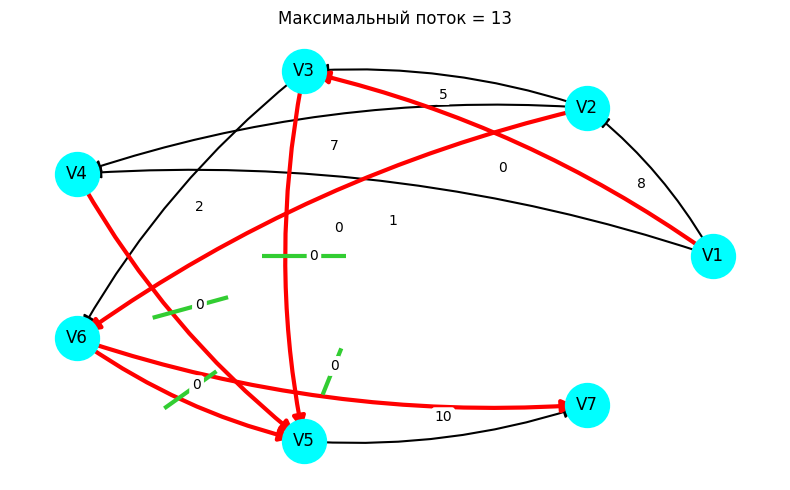

In [ ]:
max_flow, min_cut, removed = ford_fulkerson_draw(H, "V1", "V7", pos)